In [1]:
import numpy as np
import pickle
import os
from sklearn.model_selection import train_test_split
from collections import namedtuple
import matplotlib.pyplot as plt
import cv2

import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization, Activation
from keras.optimizers import Adam, SGD
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint

C:\Users\windo\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
Config = namedtuple('Config', ['batch_size', 'image_shape', 'num_classes', 'epochs'])
active_config = Config(32, (28,28,1), 4, 50)

In [3]:
class Dataset():
    DATA_DIR_NAME = 'data'
    TRAINING_IMG_FILENAME = 'train_image.pkl' 
    TRAINING_LABEL_FILENAME = 'train_label.pkl'
    TESTING_IMG_FILENAME = 'test_image.pkl'
    
    def __init__(self, validation_size=0.1):
        self.validation_size = validation_size
        self.build()
    
    @property
    def training_set_size(self):
        return len(self.training_images)
    
    @property
    def validation_set_size(self):
        return len(self.validation_images)
    
    @property
    def test_set_size(self):
        return len(self.test_set)
    
    
    def build(self):
        self.images = self.load_pickle(os.path.join(self.DATA_DIR_NAME, self.TRAINING_IMG_FILENAME))
        self.labels = self.load_pickle(os.path.join(self.DATA_DIR_NAME, self.TRAINING_LABEL_FILENAME))
        self.training_images, self.validation_images, self.training_labels, self.validation_labels = train_test_split(self.images, self.labels, test_size=self.validation_size, random_state=1)
        
        self.training_set = self.build_set(self.training_images, self.training_labels)
        self.validation_set = self.build_set(self.validation_images, self.validation_labels)
        self.test_set = self.load_pickle(os.path.join(self.DATA_DIR_NAME, self.TESTING_IMG_FILENAME))
        
    def build_set(self, images, labels):
        return [images, labels]
        
    def load_pickle(self, filename, mode='rb'):
        data = pickle.load(open(filename, mode))
        data = np.array(data, dtype='float32')
        return data

In [4]:
#TODO

dataset = Dataset()
print(dataset.training_set[0].shape, dataset.validation_set[0].shape)
print(dataset.training_set[1].shape, dataset.validation_set[1].shape)
print(dataset.training_set_size, dataset.validation_set_size, dataset.test_set_size)

(7200, 784) (800, 784)
(7200,) (800,)
7200 800 2000


In [5]:
class DatasetProvider():
    def __init__(self, augment=False, validation_size=0.1, batch_size=None, num_classes=None):
        self.dataset = Dataset(validation_size)
        self.augment = augment
        self.batch_size = batch_size or active_config.batch_size
        self.num_classes = num_classes or active_config.num_classes
    
    @property
    def training_steps(self):
        return int(dataset.training_set_size/ self.batch_size)
    
    @property
    def validation_steps(self):
        return int(dataset.test_set_size/ self.batch_size)
    
    def training_set(self):
        for batch in self.generate_batch(self.dataset.training_set):
            yield batch
    
    def validation_set(self):
        for batch in self.generate_batch(self.dataset.validation_set):
            yield batch
    
    def generate_batch(self, img_label_set):
        while True:
            all_idx = np.arange(len(img_label_set[0]))
            random_idx = np.random.choice(all_idx, size=self.batch_size)
            random_img = img_label_set[0][random_idx]
            random_label = img_label_set[1][random_idx]
            yield self.preprocess_batch([random_img, random_label])
            
    def preprocess_batch(self, img_label_batch):
        return self.preprocess_images(img_label_batch[0]), self.preprocess_labels(img_label_batch[1])
    
    def preprocess_images(self, imgs):
        #TODO add augment code
        imgs = np.reshape(imgs, (imgs.shape[0], 28, 28, 1))
        if self.augment:
            augmented_images = []
            for img in imgs:
                if np.random.choice([True, False]):
                    img = img[:, ::-1, :]
                
                value = np.random.uniform(0.8, 1.2)
                img = img * value
                img = np.clip(img, a_min=0.0, a_max=255.0)
                
                augmented_images.append(img)
            imgs = np.array(augmented_images)
            imgs = imgs/255.
        return imgs
    
    def preprocess_labels(self, labels):
        labels[labels == 2] = 1
        labels[labels == 3] = 2
        labels[labels == 6] = 3
        return to_categorical(labels, num_classes=self.num_classes)

In [6]:
dataset_provider = DatasetProvider()
batch = next(dataset_provider.training_set())
batch[0].shape, batch[1].shape

((32, 28, 28, 1), (32, 4))

In [7]:
class ImageClassifierModel():
    
    def __init__(self, learning_rate=0.001, print_summary=False, image_shape=None, num_classes=None):
        #TODO
        #initialize params and hyperparams
        self.image_shape = image_shape or active_config.image_shape
        self.num_classes = num_classes or active_config.num_classes
        self.optimizer = Adam(lr=learning_rate)
        self.print_summary = print_summary
        self.model = self.build()
    
    def build(self):
        input_layer = Input(shape=self.image_shape)
        x = Conv2D(filters=32, kernel_size=(5,5))(input_layer)
        x = Activation('relu')(x)
        x = Dropout(0.5)(x)
        x = Conv2D(filters=64, kernel_size=(3,3))(x)
        x = Activation('relu')(x)
        x = Dropout(0.5)(x)
        x = Flatten()(x)
        x = Dense(units=2048)(x)
        x = Activation('relu')(x)
        x = Dropout(0.7)(x)
        x = Dense(units=1024)(x)
        x = Activation('relu')(x)
        x = Dropout(0.7)(x)
        x = Dense(units=512)(x)
        x = Activation('relu')(x)
        output_layer = Dense(units=self.num_classes, activation='softmax')(x)
        
        model = Model(inputs=input_layer, outputs=output_layer)
        
        if self.print_summary:
            print(model.summary())
        
        model.compile(optimizer=self.optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        
        return model    

In [8]:
class Training():
    def __init__(self, augment=False, learning_rate=0.001, print_summary=False, plot_graph=False, epochs=None):
        
        self.dataset_provider = DatasetProvider(augment)
        self.model = ImageClassifierModel(learning_rate, print_summary).model
        self.epochs = epochs or active_config.epochs
        self.plot_graph = plot_graph
        self.def_callbacks()
    
    def def_callbacks(self):
        #TODO Define Callbacks
        early_stop = EarlyStopping(monitor='val_acc', min_delta=0.05, patience=10)
        self.callbacks = [early_stop]
    
    def run(self):
        self.history = self.model.fit_generator(self.dataset_provider.training_set(), 
                                                steps_per_epoch=self.dataset_provider.training_steps, 
                                                epochs=self.epochs, 
                                                validation_data=self.dataset_provider.validation_set(), 
                                                validation_steps=self.dataset_provider.validation_steps,
                                                callbacks=self.callbacks)
        
        
        xtrain, ytrain = self.dataset_provider.dataset.training_set
        xval, yval = self.dataset_provider.dataset.validation_set
        
        self.training_evaluation = self.model.evaluate(xtrain.reshape(7200, 28, 28, 1), self.dataset_provider.preprocess_labels(ytrain))
        self.validation_evaluation = self.model.evaluate(xval.reshape(800, 28, 28, 1), self.dataset_provider.preprocess_labels(yval))
        
        print("\n\nTraining Loss:{}       Training Accuracy:{}".format(self.training_evaluation[0], self.training_evaluation[1]))
        print("Validation Loss:{}     Validation Accuracy:{}".format(self.validation_evaluation[0], self.validation_evaluation[1]))
        
        if self.plot_graph:
            print('\n\n')
            fig, axes = plt.subplots(1,2, figsize=(15,5))
            axes[0].plot(train.history.history['val_loss'])
            axes[0].plot(train.history.history['loss'])
            axes[0].set_title('Model Loss')
            axes[0].set_ylabel('Loss')
            axes[0].set_xlabel('Epochs')
            axes[0].legend(['val_loss','training_loss'])

            axes[1].plot([i*100 for i in train.history.history['val_acc']])
            axes[1].plot([i*100 for i in train.history.history['acc']])
            axes[1].set_title('Model Accuracy')
            axes[1].set_ylabel('Accuracy')
            axes[1].set_xlabel('Epochs')
            axes[1].legend(['val_acc','training_acc'])
            
    
    def visualize(self):
        return
        #TODO
        # 1. Vizualize augmented images
        # 2. vizualize model history

The following block is the implementation of a basic model with a single convolutional layer and two dense hidden layers with relu activation .......................
The accuracy and loss of the following model is similar that means it is not overfitiing but not good enough for the dataset

        input_layer = Input(shape=self.image_shape)
        x = Conv2D(filters=32, kernel_size=(3,3))(input_layer)
        x = Activation('relu')(x)
        x = Flatten()(x)
        x = Dense(units=1024)(x)
        x = Activation('relu')(x)
        x = Dense(units=512)(x)
        x = Activation('relu')(x)
        output_layer = Dense(units=self.num_classes, activation='softmax')(x)

Change kernel size of the CNN layer

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_4 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 21632)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              22152192  
_________________________________________________________________
activation_5 (Activation)    (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
__________

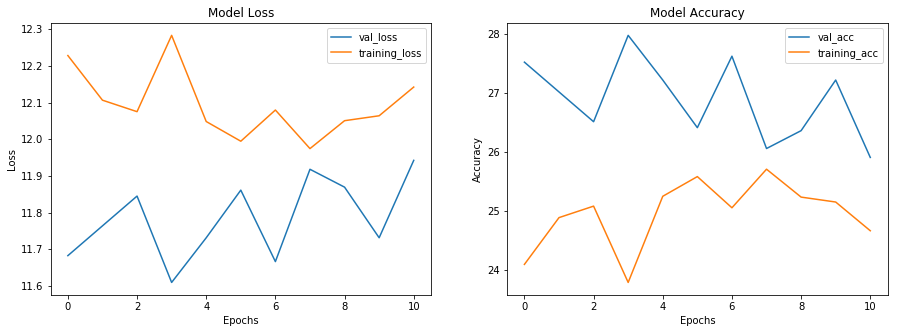

In [12]:
train = Training(print_summary=True, plot_graph=True)
train.run()

1. change arch by changing kernel size or adding more layers
2. Increase data size by augmenting data

Changed kernel size of the CNN

        input_layer = Input(shape=self.image_shape)
        x = Conv2D(filters=32, kernel_size=(5,5))(input_layer)
        x = Activation('relu')(x)
        x = Flatten()(x)
        x = Dense(units=1024)(x)
        x = Activation('relu')(x)
        x = Dense(units=512)(x)
        x = Activation('relu')(x)
        output_layer = Dense(units=self.num_classes, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
activation_7 (Activation)    (None, 24, 24, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              18875392  
_________________________________________________________________
activation_8 (Activation)    (None, 1024)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               524800    
__________

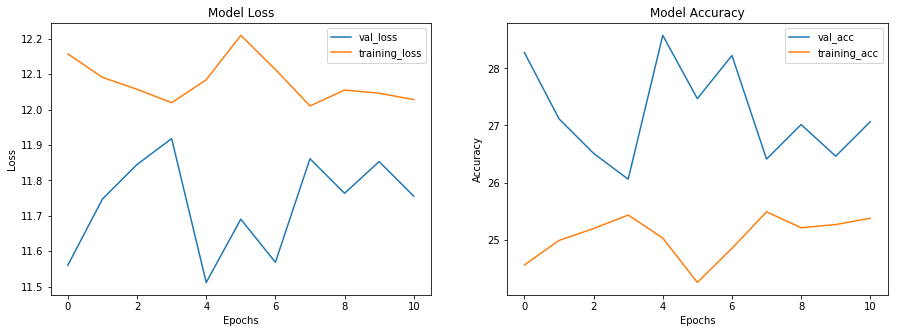

In [14]:
train = Training(print_summary=True, plot_graph=True)
train.run()

increased but not good enough


Change arch by adding layers
Added one more CNN layer after the first cnn keeping all the params same

        input_layer = Input(shape=self.image_shape)
        x = Conv2D(filters=32, kernel_size=(5,5))(input_layer)
        x = Activation('relu')(x)
        x = Conv2D(filters=64, kernel_size=(3,3))(x)
        x = Activation('relu')(x)
        x = Flatten()(x)
        x = Dense(units=1024)(x)
        x = Activation('relu')(x)
        x = Dense(units=512)(x)
        x = Activation('relu')(x)
        output_layer = Dense(units=self.num_classes, activation='softmax')(x)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
activation_10 (Activation)   (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
activation_11 (Activation)   (None, 22, 22, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 30976)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 1024)              31720448  
__________

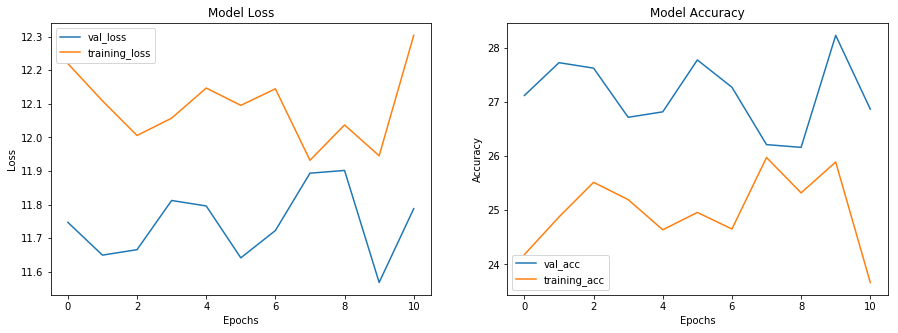

In [16]:
train = Training(print_summary=True, plot_graph=True)
train.run()

increased but not very good

Augment Data


        input_layer = Input(shape=self.image_shape)
        x = Conv2D(filters=32, kernel_size=(5,5))(input_layer)
        x = Activation('relu')(x)
        x = Conv2D(filters=64, kernel_size=(3,3))(x)
        x = Activation('relu')(x)
        x = Flatten()(x)
        x = Dense(units=1024)(x)
        x = Activation('relu')(x)
        x = Dense(units=512)(x)
        x = Activation('relu')(x)
        output_layer = Dense(units=self.num_classes, activation='softmax')(x)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
activation_14 (Activation)   (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
activation_15 (Activation)   (None, 22, 22, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 30976)             0         
_________________________________________________________________
dense_14 (Dense)             (None, 1024)              31720448  
__________

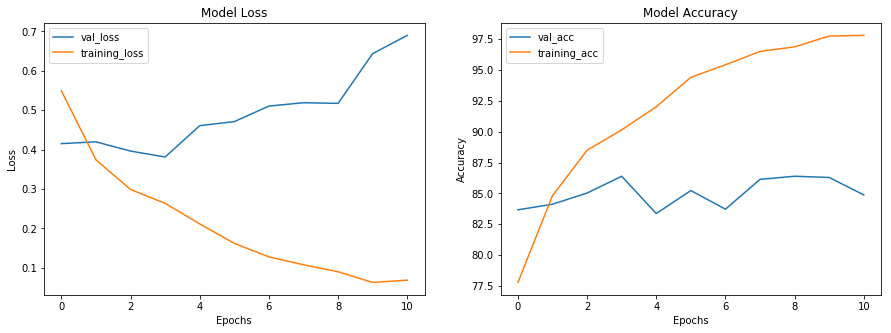

In [17]:
train = Training(augment=True, print_summary=True, plot_graph=True)
train.run()

model is  overfitting
accuracy increased but
the training accuracy is greater than the validation accuracy. therefore the model is overfitting
two methods:
1. Add dropout
2. Add legularization

Add Dropout layers

        input_layer = Input(shape=self.image_shape)
        x = Conv2D(filters=32, kernel_size=(5,5))(input_layer)
        x = Activation('relu')(x)
        x = Dropout(0.5)(x)
        x = Conv2D(filters=64, kernel_size=(3,3))(x)
        x = Activation('relu')(x)
        x = Dropout(0.5)(x)
        x = Flatten()(x)
        x = Dense(units=1024)(x)
        x = Activation('relu')(x)
        x = Dropout(0.5)(x)
        x = Dense(units=512)(x)
        x = Activation('relu')(x)
        output_layer = Dense(units=self.num_classes, activation='softmax')(x)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
activation_18 (Activation)   (None, 24, 24, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
activation_19 (Activation)   (None, 22, 22, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 22, 22, 64)        0         
__________

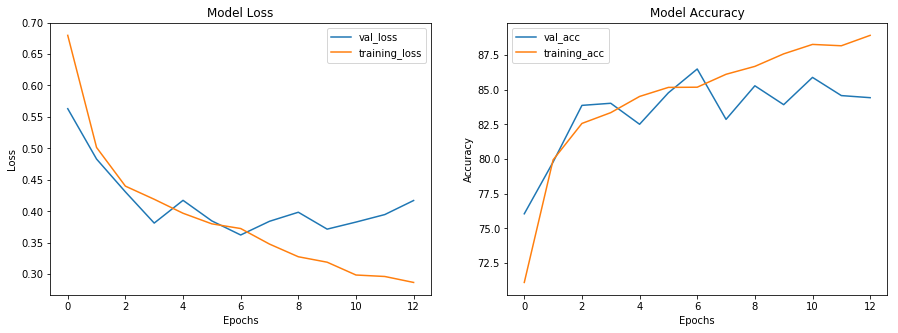

In [20]:
train = Training(augment=True, print_summary=True, plot_graph=True)
train.run()

Model not overfitting
after seveeral tries to increase the accuracy, final model 

        input_layer = Input(shape=self.image_shape)
        x = Conv2D(filters=32, kernel_size=(5,5))(input_layer)
        x = Activation('relu')(x)
        x = Dropout(0.5)(x)
        x = Conv2D(filters=64, kernel_size=(3,3))(x)
        x = Activation('relu')(x)
        x = Dropout(0.5)(x)
        x = Flatten()(x)
        x = Dense(units=2048)(x)
        x = Activation('relu')(x)
        x = Dropout(0.7)(x)
        x = Dense(units=1024)(x)
        x = Activation('relu')(x)
        x = Dropout(0.7)(x)
        x = Dense(units=512)(x)
        x = Activation('relu')(x)
        output_layer = Dense(units=self.num_classes, activation='softmax')(x)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
activation_1 (Activation)    (None, 24, 24, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 22, 22, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 22, 22, 64)        0         
__________

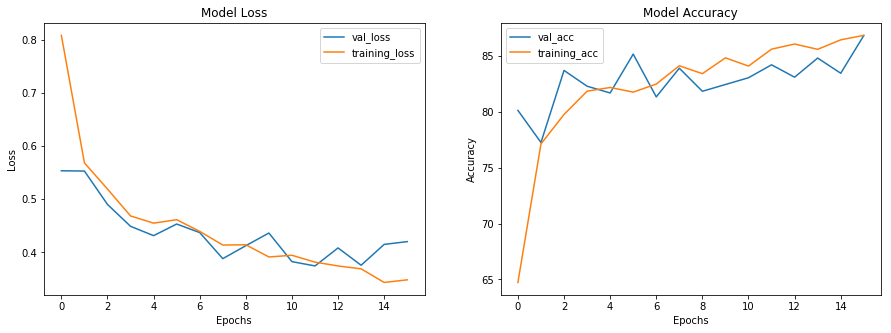

In [9]:
train = Training(augment=True, print_summary=True, plot_graph=True)
train.run()